<a href="https://colab.research.google.com/github/bavin342/Data-Science/blob/main/CQF_LSTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are going to use LSTM to predict stock movement. This is going to be a classifcation problem, i.e if the stock price goes up then we classify it as 1, if it goes down then we classify it as 0. 

We are going to be using netflix data.



In [ ]:
# Imports
!pip install yfinance 
!pip install keras-tuner --upgrade
import math
import pandas as pd
import numpy as np 
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
import time
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras_tuner as kt
from keras_tuner import HyperParameter, HyperParameters
from keras_tuner import BayesianOptimization, RandomSearch, Hyperband
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 33.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 133 kB 14.6 MB/s 


In [ ]:
# Functions Script
def plot_df(df, x_column=None, y_column=None):
    x_column : str
    y_column : str
    plt.figure(figsize = (18,9))
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    
    return plt.plot(df[y_column], 
                    "-b", 
                    label = '{}'.format(y_column)), plt.legend('{} Price'.format(y_column)) 



Building a class for all the features we are going to use for our LSTM

In [ ]:
class Features:

    def get_log_return(df):
      df['return'] = np.log(df.Close).diff().fillna(0)
      return df['return']
 

    def get_SMA(data, period=30,column='Close'):
        return data[column].rolling(window=period).mean()
    
    def get_ATR(data, period=14):
        high_low = data['High'] - data['Low']
        high_cp = np.abs(data['High'] - data['Close'].shift())
        low_cp = np.abs(data['High'] - data['Close'].shift())
        tr=pd.concat([high_low, high_cp, low_cp], axis=1) 
        true_range = np.max(tr, axis=1)
        average_TR = true_range.rolling(window=period).mean()
        return average_TR
        
    def get_Momentum(df, n):
        M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
        df = df.join(M)
        return df
    
    def get_EMA(df):
        df['EMA'] = df['Close'].ewm(span=14).mean()
        return df
        
    def get_VWAP(df):
        df['VWAP'] = (df.Volume * (df.High + df.Low) / 2).cumsum() / df.Volume.cumsum()
        return df

    def get_target(df):
      df['target'] = df['Close'] - df['Close'].shift(-1)
      df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
Features.get_target(df)
Features.get_EMA(df)
Features.get_SMA(df)
df

,Open,High,Low,Close,Adj Close,Volume,target,EMA
Date,,,,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000,1,49.848572
2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000,1,48.489388
2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700,0,47.729981
2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700,0,47.427993
2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900,1,47.519831
...,...,...,...,...,...,...,...,...
2019-12-24,334.010010,335.700012,331.600006,333.200012,333.200012,2019300,1,318.232464
2019-12-26,334.600006,336.459991,332.010010,332.630005,332.630005,3589900,1,320.152136
2019-12-27,332.959991,333.820007,326.010010,329.089996,329.089996,5036100,1,321.343851


In [ ]:
class LSTM:
  ""A Keras tuner for LSTM classifier""


    def get_



    def get_




    def get_

SyntaxError: ignored

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000
2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000
2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700
2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700
2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900
...,...,...,...,...,...,...
2019-12-24,334.010010,335.700012,331.600006,333.200012,333.200012,2019300
2019-12-26,334.600006,336.459991,332.010010,332.630005,332.630005,3589900
2019-12-27,332.959991,333.820007,326.010010,329.089996,329.089996,5036100


(None,
 ([<matplotlib.lines.Line2D at 0x7fd49d082590>],
  <matplotlib.legend.Legend at 0x7fd49d047bd0>))

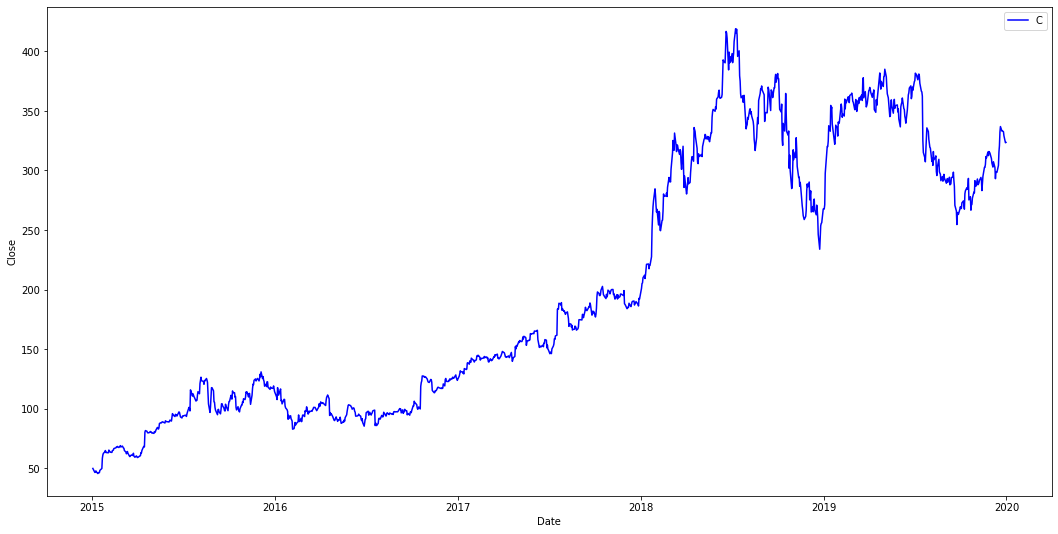

In [ ]:
# Get the data via yahoo finance
yf.pdr_override()
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 1, 1)

df = pdr.get_data_yahoo('NFLX', start, end) # Data for Netflix inc
display(df),plot_df(df,'Date', 'Close')